In [23]:
import pandas as pd
import numpy as np
import quandl
import math, datetime
from sklearn import preprocessing, model_selection, svm # Since cross_validation is deprecated
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

In [16]:
df = quandl.get("WIKI/GOOGL")
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [17]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0
2004-08-20,54.322689,0.710922,7.227007,22834300.0
2004-08-23,54.869377,3.729433,-1.227880,18256100.0
2004-08-24,52.597363,6.417469,-5.726357,15247300.0
2004-08-25,53.164113,1.886792,1.183658,9188600.0


In [18]:
forecast_col = "Adj. Close"
df.fillna(-99999, inplace=True)

In [19]:
# Predict 10% of data frame
forecast_out = int(math.ceil(0.01*len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0,69.078238
2004-08-20,54.322689,0.710922,7.227007,22834300.0,67.839414
2004-08-23,54.869377,3.729433,-1.227880,18256100.0,68.912727
2004-08-24,52.597363,6.417469,-5.726357,15247300.0,70.668146
2004-08-25,53.164113,1.886792,1.183658,9188600.0,71.219849


In [20]:
df.tail()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2018-03-21,1094.00,1.343693,0.130884,1990515.0,NaN
2018-03-22,1053.15,2.921711,-2.487014,3418154.0,NaN
2018-03-23,1026.55,3.918952,-2.360729,2413517.0,NaN
2018-03-26,1054.09,0.491419,0.332191,3272409.0,NaN
2018-03-27,1006.94,5.720301,-5.353887,2940957.0,NaN


In [21]:
X = np.array(df.drop(['label'],1))
X = preprocessing.scale(X)
X = X[:-forecast_out]
X_lately = X[-forecast_out:]
df.dropna(inplace=True)
y = np.array(df['label'])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

In [22]:
clf = LinearRegression()
# clf = svm.SVR(kernel='poly')
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)

0.9763298690923369


In [24]:
forecast_set = clf.predict(X_lately)
print(forecast_set, accuracy, forecast_out)

[1077.89843814 1092.3312773  1106.20675458 1101.03455749 1094.66153403
 1091.96687315 1090.21982353 1087.20307376 1081.21703856 1076.87098687
 1074.39262977 1093.67066778 1112.16887553 1116.92187953 1131.62832174
 1135.71303422 1134.45522911 1131.79267692 1133.62237863 1151.81580631
 1151.72129429 1161.15233004 1157.89770999 1165.49052589 1185.75291153
 1198.26662528 1193.06664025 1204.53964795 1210.05535254 1208.42969934
 1199.152954   1204.55479774 1203.21907875 1139.14159697 1087.15555694] 0.9763298690923369 35


In [25]:
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

In [27]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) -1)] + [i]

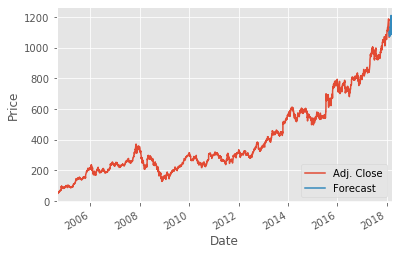

In [30]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()